**Notes:**

Validation set seharusnya menjadi referensi kita untuk menilai proses latih, sehingga menggunakan augmentasi pada set ini akan menjadikan bias pada kesimpulan kita untuk melihat trend pe epoch nya.

Penggunaan satu image generator dengan augmentasi untuk sekaligus training dan vlaidation menurut saya kurang tepat. Karena validasi seharusnya merupakan referensi, yang harus sama, sehingga tidak menjadi bias saat menyimpulkan. Sekaligus ini mungkin enjadi satu sebab trend validasi yang oscilating

Saya menyarankan untuk juga lakukan eksplorasi lagi modul augmentasi  juga arsitektur cnn yang terkini dan banyak dikembangkan. Bagaimana pendekatan untuk kasus dengan class sangat banyak dan varies

Menurunkan oscilating trend bisa juga dengan dynamic learning rate, menurunkan nilai randomness seperti di dropout, menurunkan batch size, dll. Sehinga dapat menemukan titik optimum dengan cepat dan tepat




In [ ]:
import tensorflow as tensor
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
from random import randint
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"herutriana","key":"2c1f797ca47ea0ac874fea831a498631"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iansangaji/mangga

 98% 713M/725M [00:13<00:00, 42.4MB/s]
100% 725M/725M [00:13<00:00, 57.4MB/s]


In [ ]:
import zipfile,os
zip_lcl = '/content/mangga.zip'
rzip = zipfile.ZipFile(zip_lcl, 'r')
rzip.extractall('/content')
rzip.close()

In [ ]:
dirbase = '/content/mangga_image'
dir_latih = os.path.join(dirbase, 'train')
dir_val = os.path.join(dirbase, 'valid')

In [ ]:
CLASSES, gems = [], []

for root, dirs, files in os.walk(dir_latih):
    f = os.path.basename(root)

    if len(files) > 0:
        gems.append(len(files))
        if f not in CLASSES:
            CLASSES.append(f)

gems_count = len(CLASSES)
print('{} classes with {} images in total'.format(len(CLASSES), sum(gems)))

3 classes with 300 images in total


In [ ]:
os.listdir(dir_latih)

['mangga_masak', 'mangga_busuk', 'mangga_muda']

In [ ]:
os.listdir(dir_val)

['mangga_masak', 'mangga_busuk', 'mangga_muda']

In [ ]:
latih_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest')

val_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.9,
    shear_range=0.2,
    fill_mode='nearest')

In [ ]:
batchSize = 4

In [ ]:
generator_latih = latih_generator.flow_from_directory(
    directory=dir_latih,
    target_size=(150,150),
    batch_size=batchSize,
    subset='training',
    class_mode='categorical')
generator_valid = val_generator.flow_from_directory(
    directory=dir_val,
    target_size=(150,150),
    batch_size=batchSize,
    subset='validation',
    class_mode='categorical')

Found 198 images belonging to 3 classes.
Found 176 images belonging to 3 classes.


In [ ]:
model = tensor.keras.models.Sequential([
  tensor.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
  tensor.keras.layers.MaxPooling2D(2,2),
  tensor.keras.layers.Conv2D(64,(3,3),activation='relu'),
  tensor.keras.layers.MaxPooling2D(2,2),
  tensor.keras.layers.Conv2D(128,(3,3),activation='relu'),
  tensor.keras.layers.MaxPooling2D(2,2),
  tensor.keras.layers.Flatten(),
  tensor.keras.layers.Dense(512,activation='relu'),
  tensor.keras.layers.Dense(3,activation='softmax')
  ])

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tensor.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('loss') < 0.1):
      print("\nAkurasi di atas 90%, hentikan training!")
      self.model.stop_training = True

stop = myCallback()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#earstop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
cekmodel = ModelCheckpoint(filepath='model.hdf5',monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)

In [ ]:
history = model.fit(
    generator_latih,
    steps_per_epoch=198/4, # 10243 images = batch_size * steps
    epochs=30,
    validation_data=generator_valid,
    validation_steps=176/4, # 1050 images = batch_size * steps
    verbose=2,
    callbacks=[cekmodel,stop])

Epoch 1/30

Epoch 1: val_accuracy improved from 0.25000 to 0.57386, saving model to model.hdf5
49/49 - 39s - loss: 0.9920 - accuracy: 0.5101 - val_loss: 0.8719 - val_accuracy: 0.5739 - 39s/epoch - 791ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.57386 to 0.59091, saving model to model.hdf5
49/49 - 37s - loss: 0.8673 - accuracy: 0.5758 - val_loss: 0.7777 - val_accuracy: 0.5909 - 37s/epoch - 746ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.59091 to 0.59659, saving model to model.hdf5
49/49 - 39s - loss: 0.8684 - accuracy: 0.6313 - val_loss: 0.8093 - val_accuracy: 0.5966 - 39s/epoch - 781ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.59659 to 0.61364, saving model to model.hdf5
49/49 - 37s - loss: 0.8626 - accuracy: 0.6212 - val_loss: 0.7753 - val_accuracy: 0.6136 - 37s/epoch - 751ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.61364 to 0.62500, saving model to model.hdf5
49/49 - 37s - loss: 0.8881 - accuracy: 0.6010 - val_loss: 0.8021 - val_ac

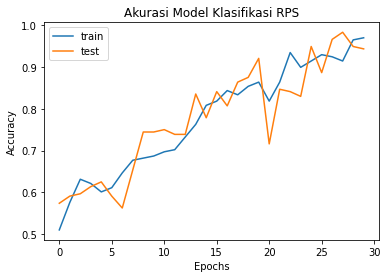

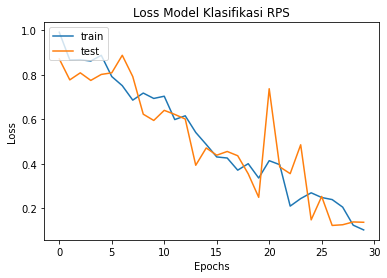

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model Klasifikasi RPS')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model Klasifikasi RPS')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pengubah = tensor.lite.TFLiteConverter.from_keras_model(model)
tflite_model = pengubah.convert()

INFO:tensorflow:Assets written to: /tmp/tmpzs_kr8ed/assets


INFO:tensorflow:Assets written to: /tmp/tmpzs_kr8ed/assets


In [ ]:
with tensor.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model.save('mangga.h5')
%cd

/root


In [ ]:
model.save('/content/mangga.hdf5')